# Imports

In [1]:
from functools import partial
import itertools
import os
import os.path as osp

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing, metrics, model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tqdm
import scipy

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG

In [2]:
pd.set_option("display.max_columns", 100)
sns.set(font_scale=1.5)

# Data

In [3]:
data_dir = osp.join("../data/")
df = pd.read_csv(osp.join(data_dir, "dengue_features_train.csv"))
labels = pd.read_csv(osp.join(data_dir, "dengue_labels_train.csv"))
print(f"Shapes before: features {df.shape}, labels {labels.shape}")
df = pd.merge(df, labels, left_on=["city", "year", "weekofyear"], right_on=["city", "year", "weekofyear"])
print(f"Shape after: features + labels {df.shape}")
df.head()

Shapes before: features (1456, 24), labels (1456, 4)
Shape after: features + labels (1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


# Data preparation

In [4]:
predictors = [
    "city", 
    "year", 
    "weekofyear", 
]
targets = ["reanalysis_max_air_temp_k", "reanalysis_dew_point_temp_k", "precipitation_amt_mm", "ndvi_se"]
final_targets = ["total_cases"]
all_targets = np.concatenate([targets, final_targets])

all_columns = np.concatenate([predictors, targets, final_targets])

df_ = df[all_columns].dropna()

print(f"Shape before {df.shape}, shape after {df_.shape}")

Shape before (1456, 25), shape after (1426, 8)


In [5]:
le_dict = {}
for var_name in ["city", "year", "weekofyear"]:
    le = preprocessing.LabelEncoder()
    df_.loc[:, var_name] = le.fit_transform(df_[var_name])
    le_dict[var_name] = le
df_.head()

,city,year,weekofyear,reanalysis_max_air_temp_k,reanalysis_dew_point_temp_k,precipitation_amt_mm,ndvi_se,total_cases
0,1,0,17,299.8,292.414286,12.42,0.198483,4
1,1,0,18,300.9,293.951429,22.82,0.162357,5
2,1,0,19,300.5,295.434286,34.54,0.157200,4
3,1,0,20,301.4,295.310000,15.36,0.227557,3
4,1,0,21,301.9,295.821429,7.52,0.251200,6


# Step 2. Sampling of chosen target variables  using univariate parametric distributions (from practice #2) with 2 different sampling methods.

### Note: we had missynchronization, so I've used non-parametric estimations of target variables distributions (histograms) instead of parametric representations. Both methods used - Inverse Transform and Geometric (Neiman) can be applied to a parametric distribution.

## Step 2.1 - Inverse Transform Sampling using histograms

In [6]:
def inv_trans_sampling_hist(values, num_samples=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
    
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    uniform_values = np.random.rand(num_samples)
    
    return inversed_cdf(uniform_values), n_bins

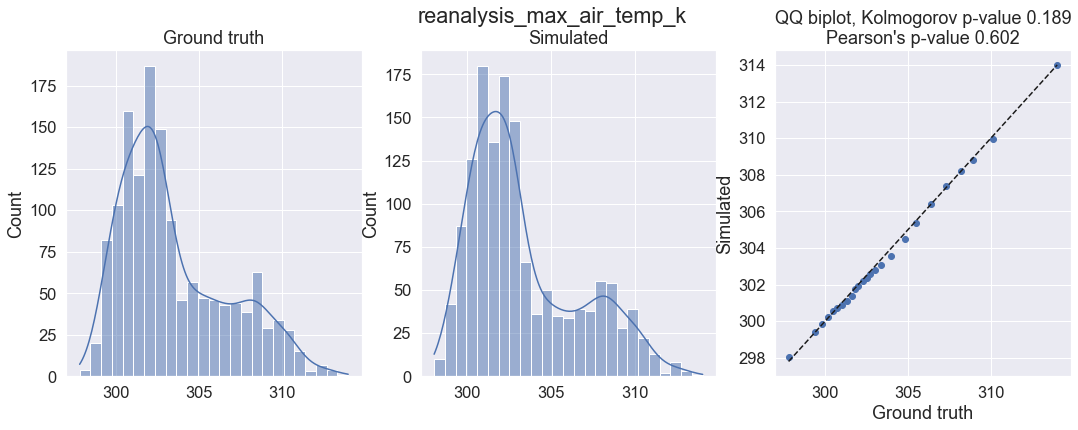

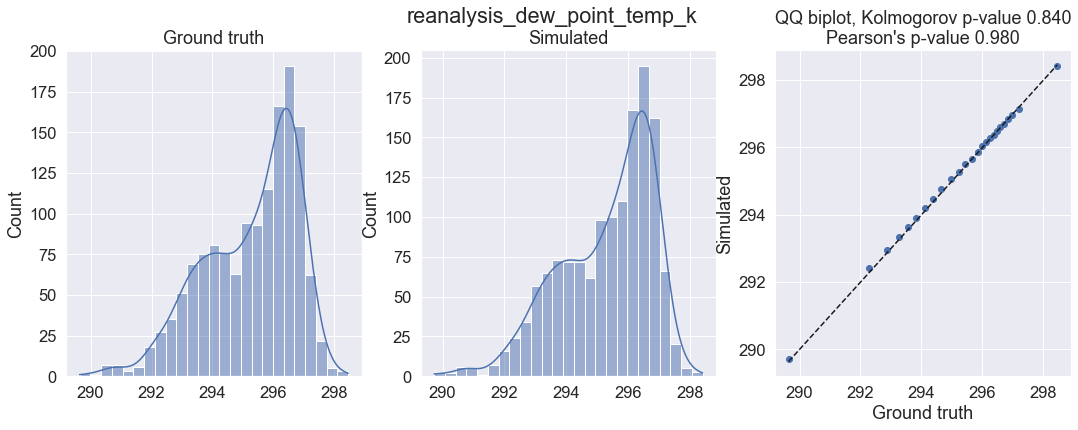

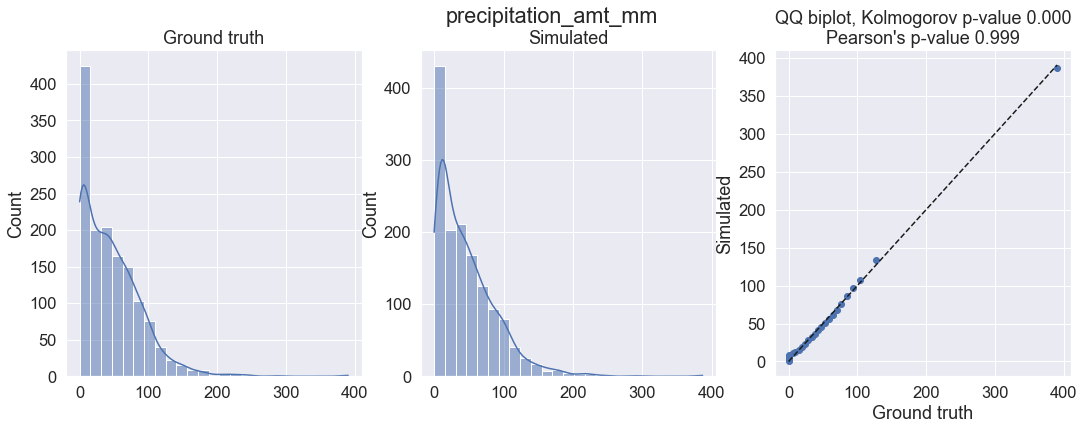

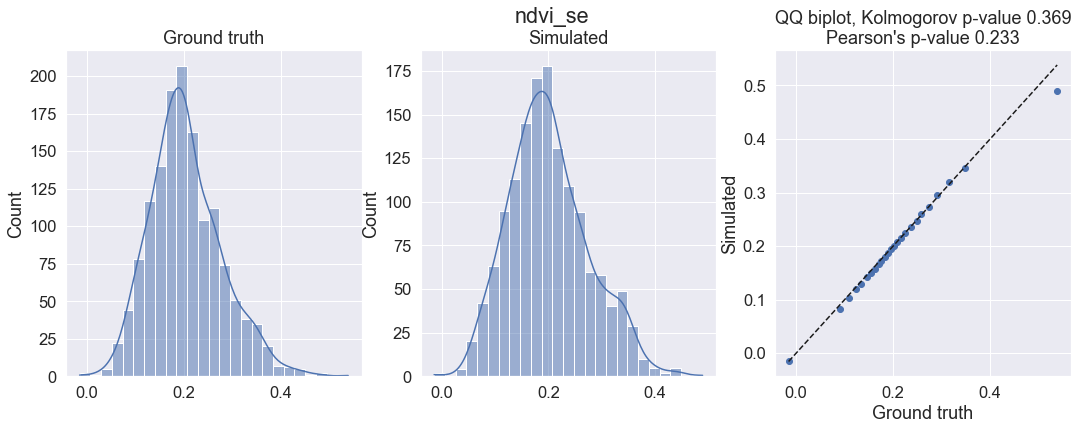

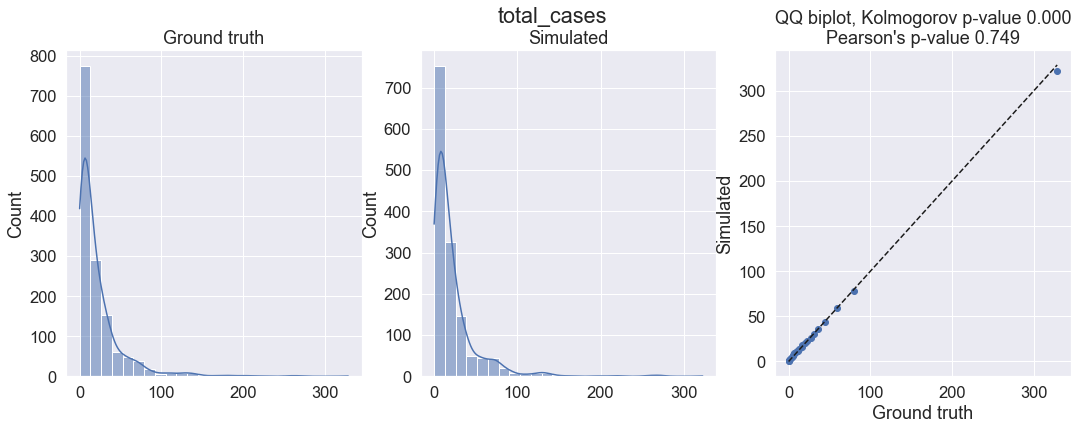

In [7]:
for target_var in all_targets:

    sampled, n_bins = inv_trans_sampling_hist(df_[target_var], num_samples=df_.shape[0])
    
    ks_stat, ks_pv = scipy.stats.ks_2samp(df_[target_var], sampled)
    
    freqs, bin_edges = np.histogram(df_[target_var], bins=n_bins)
    # Add 1 to all frequencies so that we didn't get 0 in some sampled frequencies
    freqs += 1
    freqs_sampled = np.bincount(np.concatenate([np.digitize(sampled, bin_edges) - 1, np.arange(n_bins)]))
    chi_stat, chi_pv = scipy.stats.chisquare(freqs_sampled, freqs)
    
    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(df_[target_var], percs)
    qn_sampled = np.percentile(sampled, percs)

    fig, ax = plt.subplots(ncols=3, figsize=(18, 6), sharex=False, sharey=False)
    
    sns.histplot(df_[target_var], bins=n_bins, kde=True, ax=ax[0])
    ax[0].set_xlabel(None)
    ax[0].set_title("Ground truth")
    
    sns.histplot(sampled, bins=n_bins, kde=True, ax=ax[1])
    ax[1].set_title(f"Simulated")
    
    ax[2].plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    ax[2].plot(qn_gt, qn_gt, color="k", ls="--")
    ax[2].set_xlabel("Ground truth")
    ax[2].set_ylabel("Simulated")
    ax[2].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.3f}\nPearson's p-value {chi_pv:.3f}")
    
    fig.suptitle(f"{target_var}")
    plt.plot();

## Step 2.2 - Geometric (Neiman) method of sampling using histograms

I thought of Accept-Reject sampling, but it's harder to find parameters of universal upper function for any given form of histogram.

In [8]:
def geom_sampling_hist(values, num_samples=1000, batch_size=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    left, right = np.min(bin_edges), np.max(bin_edges)
    bottom, top = np.min(hist), np.max(hist)
    
    accept_samples = np.asarray([])
    
    while accept_samples.shape[0] < num_samples:
        
        x_sampl = np.random.uniform(left, right, size=(batch_size,))
        y_sampl = np.random.uniform(bottom, top, size=(batch_size,))
        
        x_indices = np.digitize(x_sampl, bin_edges) - 1
        y_mask = (y_sampl <= hist[x_indices])
        
        accept_samples = np.concatenate([accept_samples, x_sampl[y_mask]])
        
    return accept_samples[:num_samples], n_bins

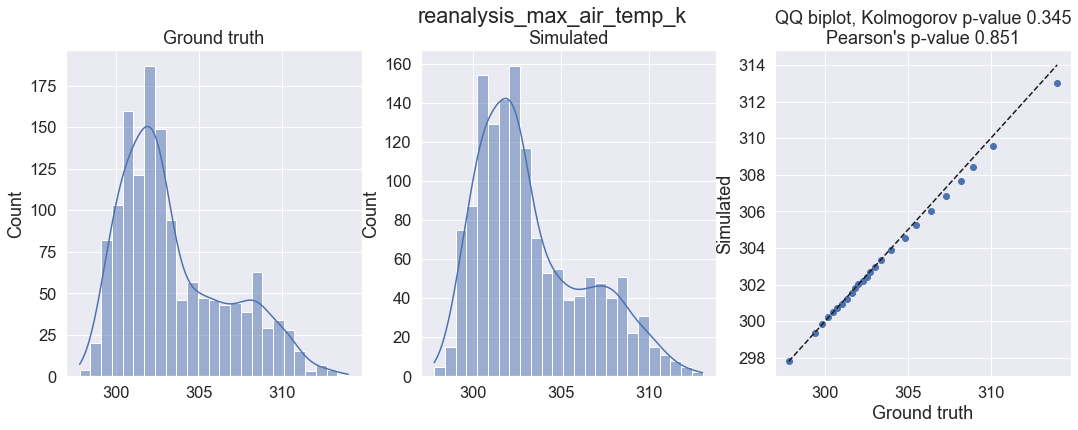

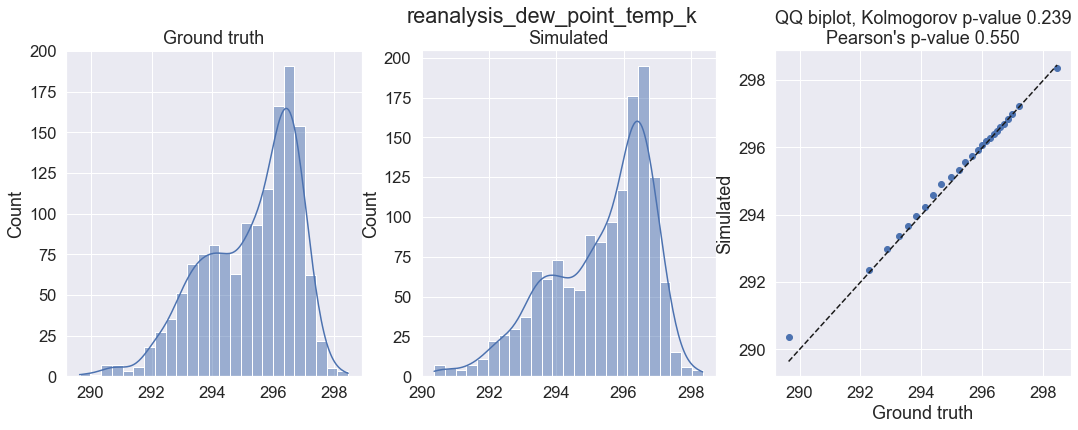

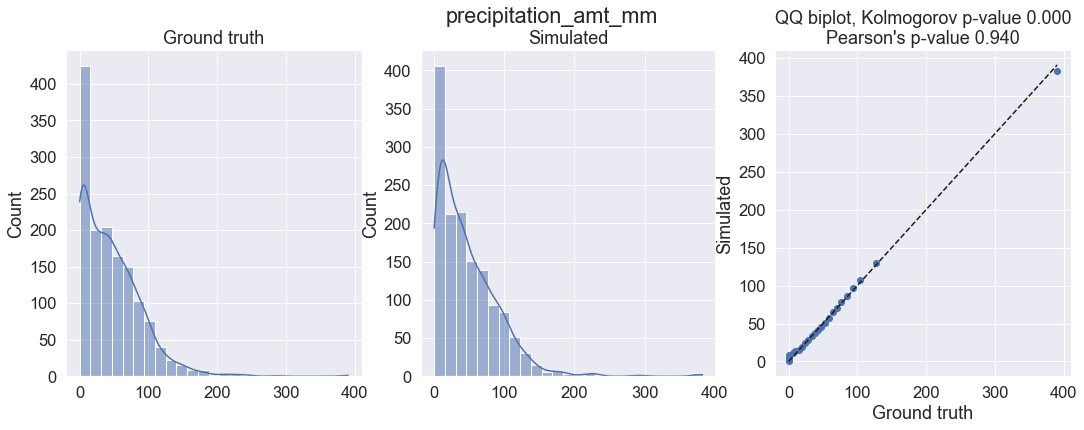

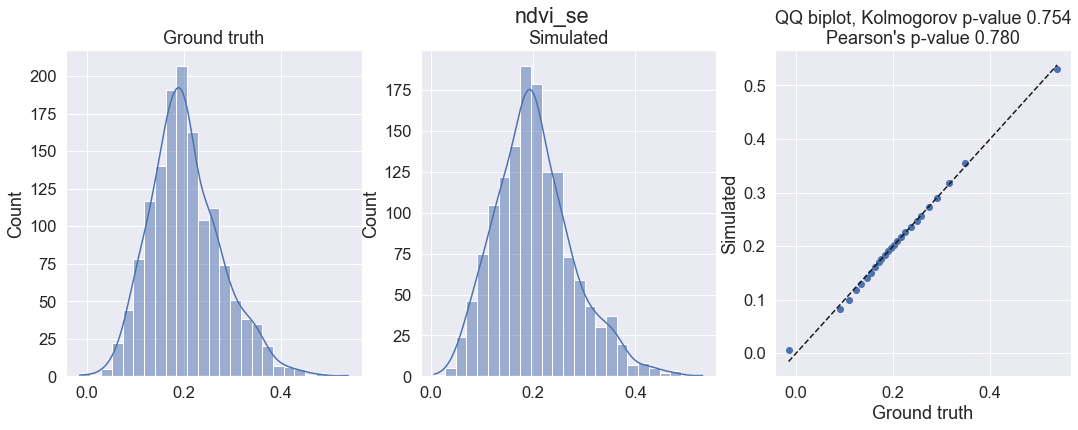

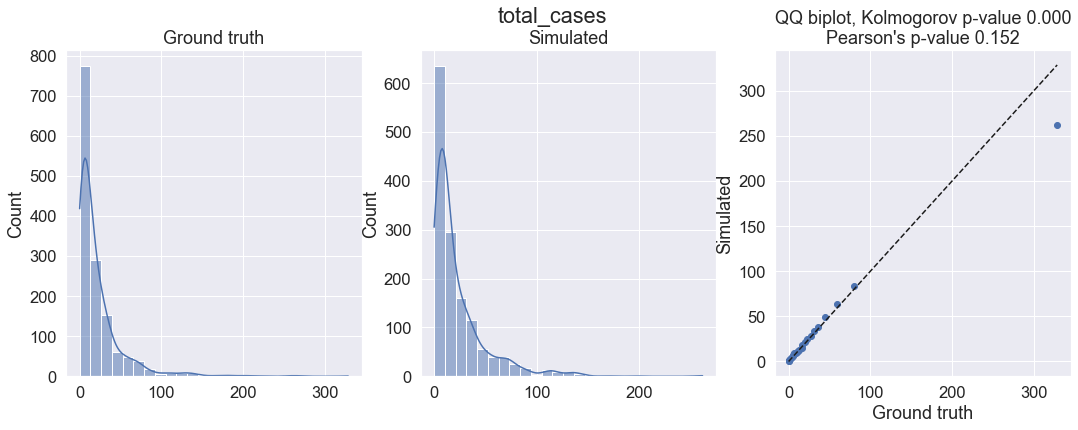

In [9]:
for target_var in all_targets:

    sampled, n_bins = geom_sampling_hist(df_[target_var], num_samples=df_.shape[0])
    
    ks_stat, ks_pv = scipy.stats.ks_2samp(df_[target_var], sampled)
    
    freqs, bin_edges = np.histogram(df_[target_var], bins=n_bins)
    # Add 1 to all frequencies so that we didn't get 0 in some sampled frequencies
    freqs += 1
    freqs_sampled = np.bincount(np.concatenate([np.digitize(sampled, bin_edges) - 1, np.arange(n_bins)]))
    chi_stat, chi_pv = scipy.stats.chisquare(freqs_sampled, freqs)
    
    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(df_[target_var], percs)
    qn_sampled = np.percentile(sampled, percs)

    fig, ax = plt.subplots(ncols=3, figsize=(18, 6), sharex=False, sharey=False)
    
    sns.histplot(df_[target_var], bins=n_bins, kde=True, ax=ax[0])
    ax[0].set_xlabel(None)
    ax[0].set_title("Ground truth")
    
    sns.histplot(sampled, bins=n_bins, kde=True, ax=ax[1])
    ax[1].set_title(f"Simulated")
    
    ax[2].plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    ax[2].plot(qn_gt, qn_gt, color="k", ls="--")
    ax[2].set_xlabel("Ground truth")
    ax[2].set_ylabel("Simulated")
    ax[2].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.3f}\nPearson's p-value {chi_pv:.3f}")
    
    fig.suptitle(f"{target_var}")
    plt.plot();

#### Combine pictures

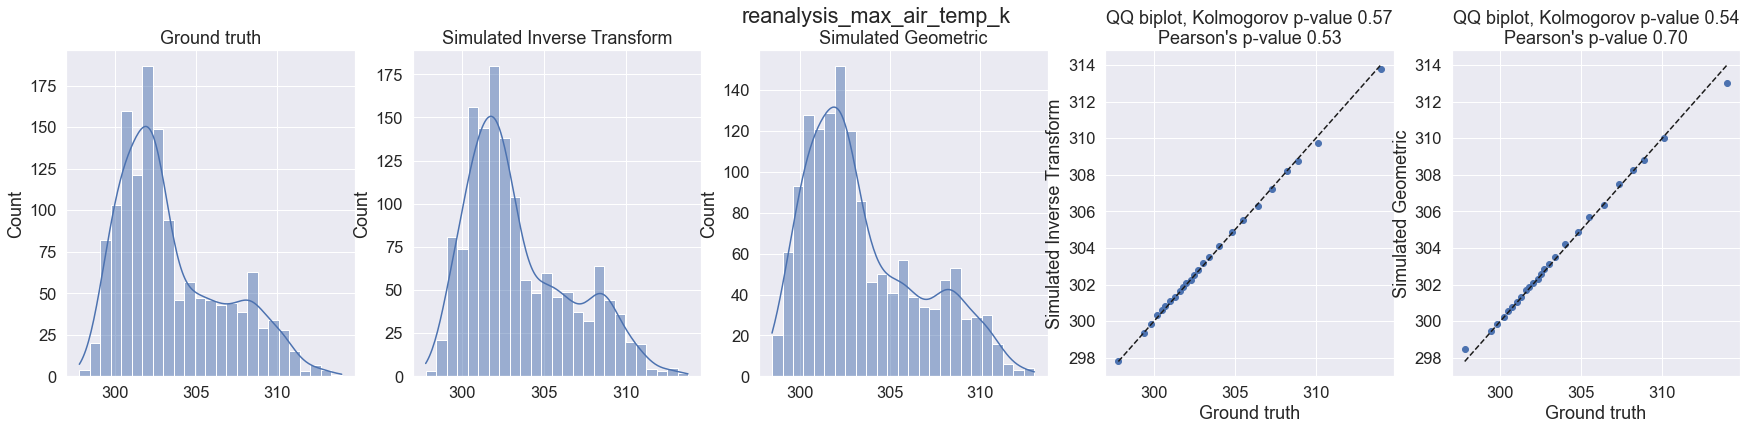

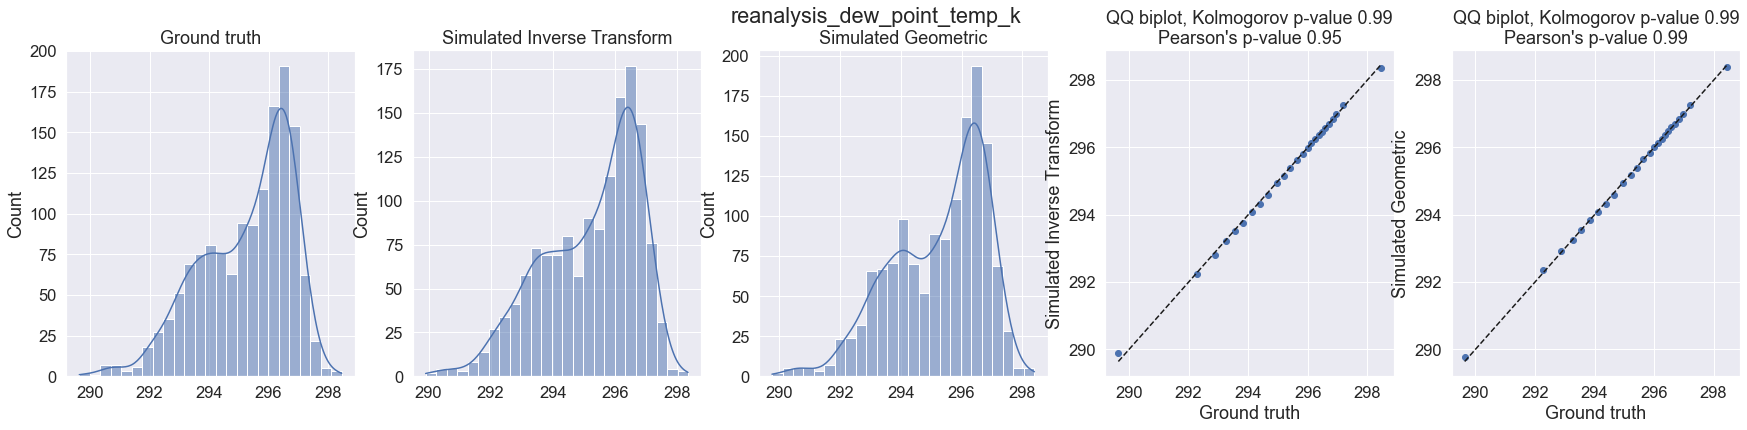

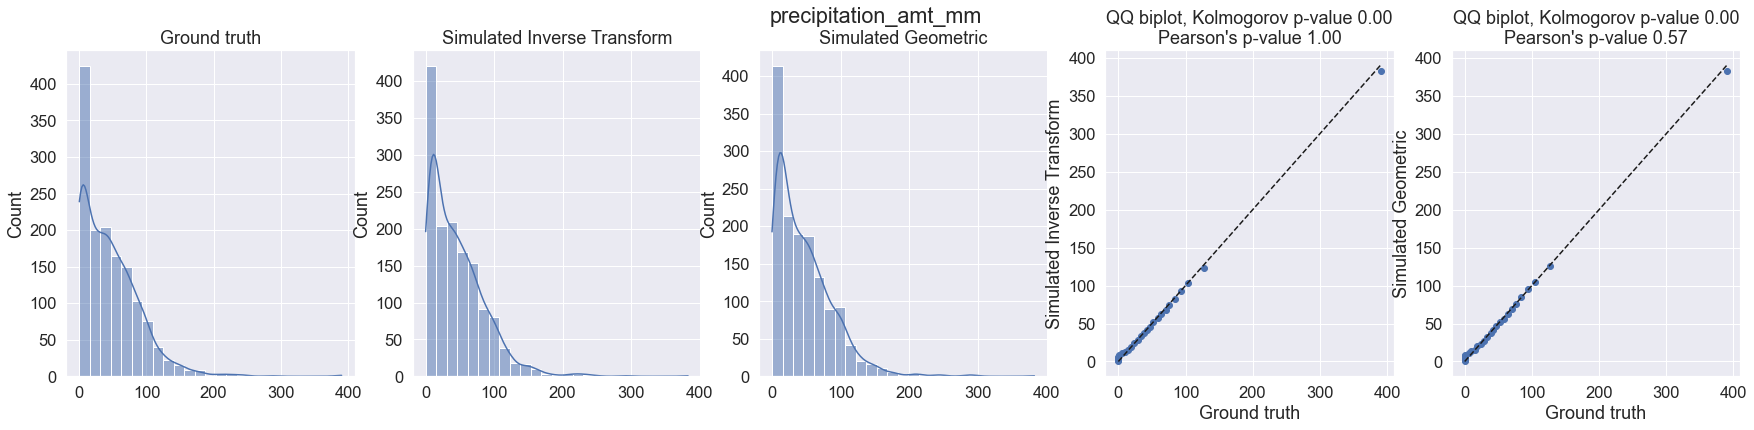

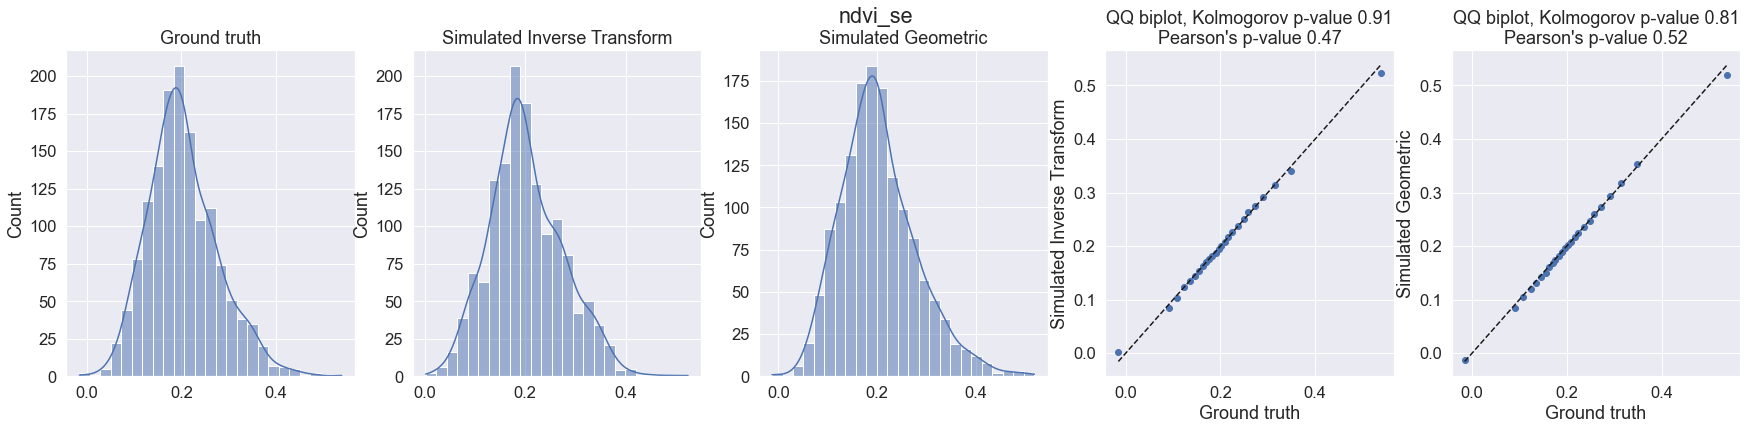

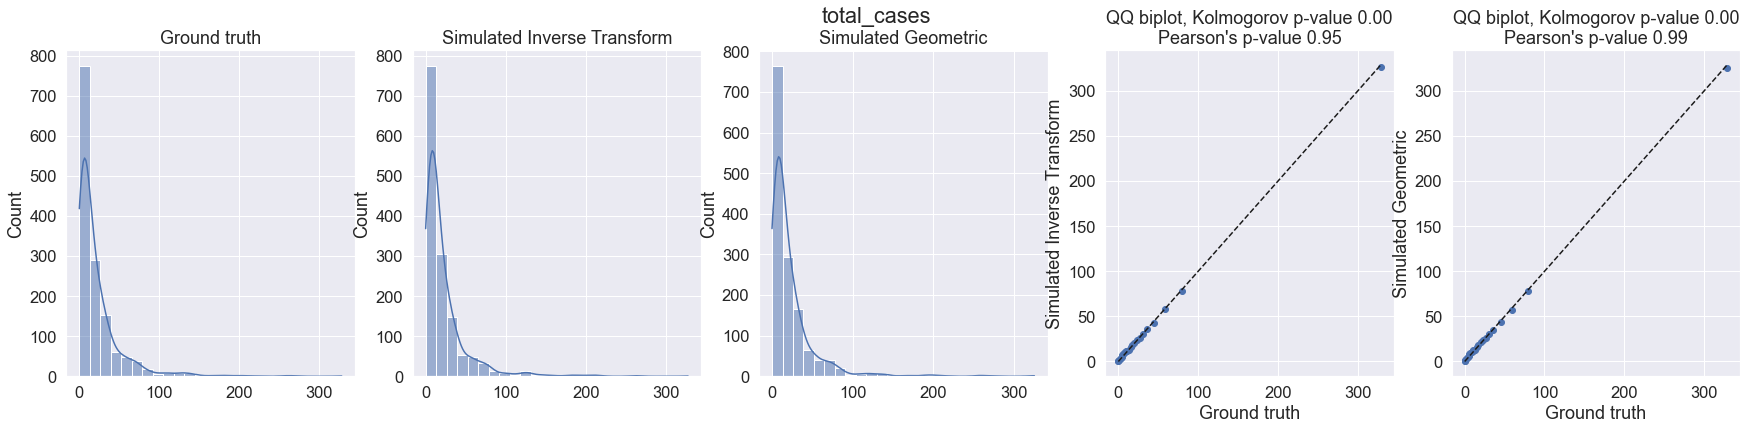

In [10]:
for target_var in all_targets:

    fig, ax = plt.subplots(ncols=5, figsize=(30, 6), sharex=False, sharey=False)
    
    sampled_inv, n_bins = inv_trans_sampling_hist(df_[target_var], num_samples=df_.shape[0])
    sampled_geom, n_bins = geom_sampling_hist(df_[target_var], num_samples=df_.shape[0])
    
    sns.histplot(df_[target_var], bins=n_bins, kde=True, ax=ax[0])
    ax[0].set_xlabel(None)
    ax[0].set_title("Ground truth")
    
    sns.histplot(sampled_inv, bins=n_bins, kde=True, ax=ax[1])
    ax[1].set_title("Simulated Inverse Transform")
    
    sns.histplot(sampled_geom, bins=n_bins, kde=True, ax=ax[2])
    ax[2].set_title("Simulated Geometric")
    
    for idx, sim_name, sampled in zip([3, 4], ["Inverse Transform", "Geometric"], [sampled_inv, sampled_geom]):
        ks_stat, ks_pv = scipy.stats.ks_2samp(df_[target_var], sampled)

        freqs, bin_edges = np.histogram(df_[target_var], bins=n_bins)
        # Add 1 to all frequencies so that we didn't get 0 in some sampled frequencies
        freqs += 1
        freqs_sampled = np.bincount(np.concatenate([np.digitize(sampled, bin_edges) - 1, np.arange(n_bins)]))
        chi_stat, chi_pv = scipy.stats.chisquare(freqs_sampled, freqs)

        percs = np.linspace(0, 100, n_bins)
        qn_gt = np.percentile(df_[target_var], percs)
        qn_sampled = np.percentile(sampled, percs)

        ax[idx].plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
        ax[idx].plot(qn_gt, qn_gt, color="k", ls="--")
        ax[idx].set_xlabel("Ground truth")
        ax[idx].set_ylabel(f"Simulated {sim_name}")
        ax[idx].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.2f}\nPearson's p-value {chi_pv:.2f}")
    
    fig.suptitle(f"{target_var}")
    plt.plot();

# Step 3. Estimation of relations between predictors and chosen target variables.

<ipython-input-11-520ce4ac0ccb>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

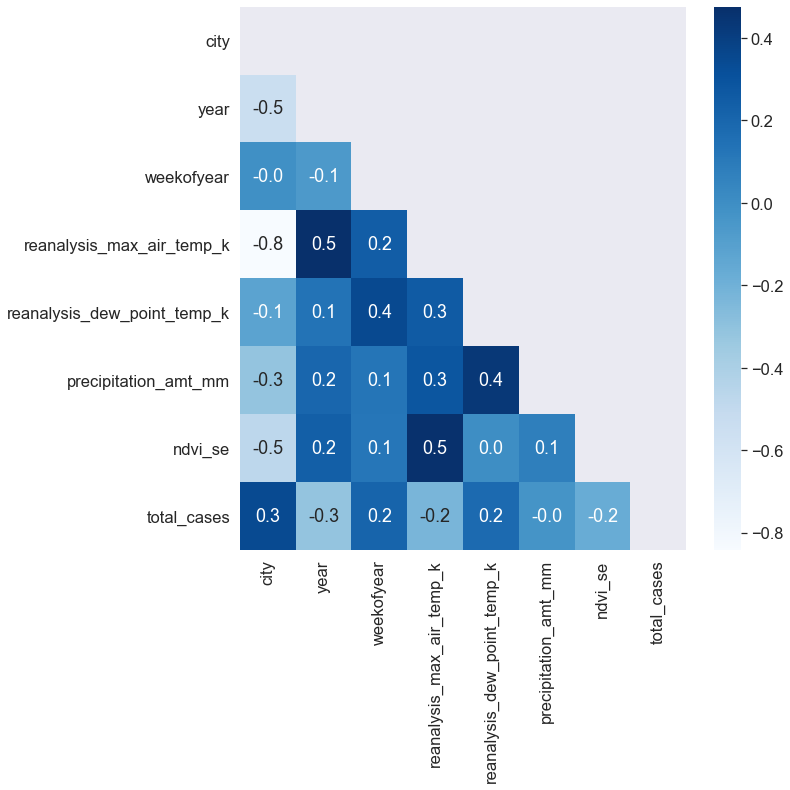

In [11]:
# Building a correlation matrix of features
corr = df_.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', ax=ax, cmap='Blues')

# Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

Scheme of dependencies:
* The main independent variables are `city`, `year`, and `weekofyear`
* `reanalysis_max_air_temp_k` depends on `city`, `year`
* `reanalysis_dew_point_temp_k` depends on `weekofyear`, `reanalysis_max_air_temp_k`
* `precipitation_amt_mm` depends on `city`, `reanalysis_max_air_temp_k`, `reanalysis_dew_point_temp_k`
* `ndvi_se` depends on `reanalysis_max_air_temp_k`
* `total_cases` is the final level which depend on `reanalysis_max_air_temp_k`, `reanalysis_dew_point_temp_k`, `nvdi_se`

In [12]:
edges = {
    "city": ["reanalysis_max_air_temp_k", "precipitation_amt_mm"],
    "year": ["reanalysis_max_air_temp_k"],
    "weekofyear": ["reanalysis_dew_point_temp_k"],
    "reanalysis_max_air_temp_k": ["reanalysis_dew_point_temp_k", "ndvi_se"],
    "reanalysis_dew_point_temp_k": ["precipitation_amt_mm", "total_cases"],
    "precipitation_amt_mm": [],
    "ndvi_se": ["total_cases"],
}

edges_list = []
for out_var, in_vars in edges.items():
    for in_var in in_vars:
        edges_list.append((out_var, in_var))


In [13]:
edges_list

[('city', 'reanalysis_max_air_temp_k'),
 ('city', 'precipitation_amt_mm'),
 ('year', 'reanalysis_max_air_temp_k'),
 ('weekofyear', 'reanalysis_dew_point_temp_k'),
 ('reanalysis_max_air_temp_k', 'reanalysis_dew_point_temp_k'),
 ('reanalysis_max_air_temp_k', 'ndvi_se'),
 ('reanalysis_dew_point_temp_k', 'precipitation_amt_mm'),
 ('reanalysis_dew_point_temp_k', 'total_cases'),
 ('ndvi_se', 'total_cases')]

## Transform

All continuous distributions should be converted to discrete.

In [14]:
df_proc = df_.copy()

est = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discr = est.fit_transform(df_proc.values[:, 1:])
df_proc[df_proc.columns[1:]] = data_discr

## Define network structure

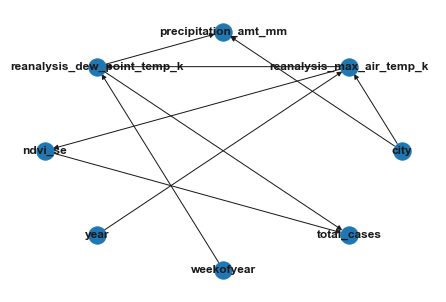

In [15]:
network1 = BayesianModel(edges_list)

G_MAN = nx.DiGraph()
G_MAN.add_edges_from(network1.edges())
pos = nx.layout.circular_layout(G_MAN)
nx.draw(G_MAN, pos, with_labels=True, font_weight='bold')

In [16]:
# network1.add_cpds(*cpds.values())
network1.fit(df_proc)

print(network1.check_model())

True


### Scores of hand-crafted networks

In [17]:
print(f"K2 score of hand-crafted model {K2Score(df_proc).score(network1):.2f}")
print(f"BIC score of hand-crafted model {BicScore(df_proc).score(network1):.2f}")

K2 score of hand-crafted model -13442.08
BIC score of hand-crafted model -13908.86


## Sample from hand-created network

In [18]:
def sampling (bn: DAG, data: pd.DataFrame, n: int=100, new: bool=False):
    if new:
        bn_new = BayesianModel(bn.edges())
        bn_new.fit(data)
    else:
        bn_new = bn
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

In [19]:
df_s1 = sampling(network1, df_proc, n=2000, new=True)

Generating for node: precipitation_amt_mm: 100%|██████████| 8/8 [00:00<00:00, 99.77it/s]


# Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

### Tree search

In [20]:
search = TreeSearch(df_proc, root_node="city")
tree = search.estimate()

Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 1155.52it/s]


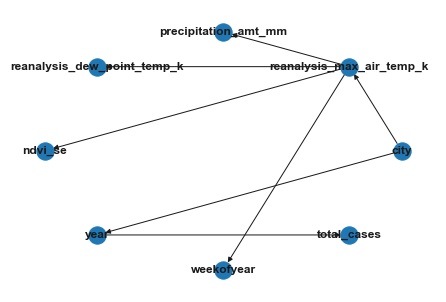

In [21]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(tree.edges())
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [22]:
print(f"K2 score of tree model {K2Score(df_proc).score(tree):.2f}")
print(f"BIC score of tree model {BicScore(df_proc).score(tree):.2f}")

K2 score of tree model -12907.94
BIC score of tree model -13017.48


In [23]:
df_stree = sampling(tree, df_proc, n=2000, new=True)

Generating for node: reanalysis_dew_point_temp_k: 100%|██████████| 8/8 [00:00<00:00, 118.97it/s]


### Score-based K2 score estimator with Hill-Climbing strategy

In [24]:
search = HillClimbSearch(df_proc, scoring_method=K2Score(df_proc))
k2_unconstr = search.estimate()

  0%|          | 15/1000000 [00:01<20:57:47, 13.25it/s]


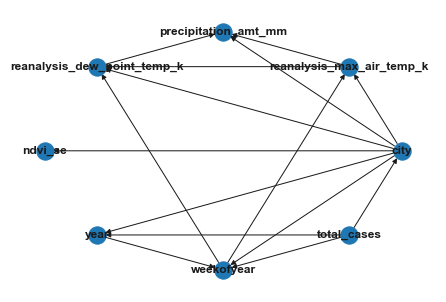

In [25]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(k2_unconstr.edges())
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [26]:
print(f"K2 score of unconstrained model {K2Score(df_proc).score(k2_unconstr):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_proc).score(k2_unconstr):.2f}")

K2 score of unconstrained model -12448.03
BIC score of unconstrained model -14174.17


In [27]:
df_k2u = sampling(k2_unconstr, df_proc, n=2000, new=True)

Generating for node: precipitation_amt_mm: 100%|██████████| 8/8 [00:00<00:00, 75.77it/s]


We see, that somehow `weekofyear`, `year`, and `city` are dependent variables, which is complete nonsence, as well as `total_cases` cannot be predictor. Let's add constraints to our model and fit it with other estimator and score.

In [28]:
blacklist = []
blacklist.extend([(x, y) for x in df_proc.columns.to_list() for y in ["year", "weekofyear", "city"] if x != y])
blacklist.extend([(y, x) for x in df_proc.columns.to_list() for y in ["total_cases"]])

In [29]:
search = HillClimbSearch(df_proc, scoring_method=K2Score(df_proc))
k2_constr = search.estimate(black_list=blacklist)

  0%|          | 11/1000000 [00:00<20:04:47, 13.83it/s]


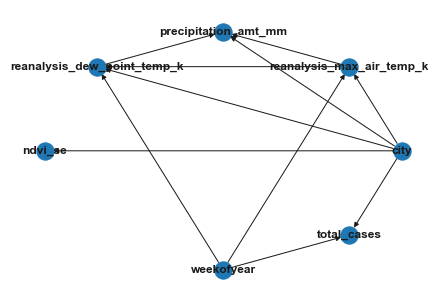

In [30]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(k2_constr.edges())
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [31]:
print(f"K2 score of unconstrained model {K2Score(df_proc).score(k2_constr):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_proc).score(k2_constr):.2f}")

K2 score of unconstrained model -12814.76
BIC score of unconstrained model -13927.55


In [32]:
df_k2c = sampling(k2_constr, df_proc, n=2000, new=True)

Generating for node: precipitation_amt_mm: 100%|██████████| 7/7 [00:00<00:00, 74.12it/s]


# Step 6. Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

## Multiclass classification with respect to `total_cases` variable

I also tried to make classification for the other variables (since the code is completely universal), but I've got numerous Zero Division errors and gave up.

The metric selected - multiclass ROC AUC one-versus-rest with macroaverage between classes.

In [33]:
def fit_predict_network(network, df_train, df_test, target_variable):
    bn_new = BayesianModel(network.edges())
    bn_new.fit(df_train)
    
    X_test = df_test[list(bn_new.nodes())].drop(target_variable, axis=1)
    scores = bn_new.predict_probability(X_test).values

    y_true = df_test[[target_variable]].values
    ohe = preprocessing.OneHotEncoder()
    y_true = ohe.fit_transform(y_true).toarray()
    
    try:
        auc = metrics.roc_auc_score(y_true, scores, multi_class='ovr')
    except ValueError:
        auc = None
    
    return auc


def cross_validate_network(network, data, cv_splitter, target_variable="total_cases"):
    columns = data.columns
    X = data.drop(target_variable, axis=1)
    y = data[[target_variable]]
    
    aucs = []
    for train_indices, test_indices in tqdm.tqdm(cv_splitter.split(X, y), total=cv_splitter.get_n_splits(), desc="Splits"):
        df_train = data.iloc[train_indices]
        df_test = data.iloc[test_indices]
        
        auc = fit_predict_network(network, df_train, df_test, target_variable=target_variable)
        aucs.append(auc)
        
    return aucs

In [34]:
cv = model_selection.StratifiedKFold(n_splits=4, shuffle=True, random_state=24)

data_aucs = {}

for net_name, net_arch in tqdm.tqdm(zip(
    ["manual", "tree", "k2_unconstrained", "k2_constrained"],
    [network1, tree, k2_unconstr, k2_constr]
), total=4, desc="Models"):
    aucs = cross_validate_network(net_arch, df_proc, cv_splitter=cv)
    data_aucs[net_name] = aucs

Models: 100%|██████████| 4/4 [05:11<00:00, 77.97s/it]


In [35]:
df_auc = pd.DataFrame(data_aucs)
df_auc

,manual,tree,k2_unconstrained,k2_constrained
0,0.620777,0.750347,0.780020,0.758930
1,0.706263,0.758821,0.889081,0.831695
2,0.631039,0.730109,0.846559,0.797885
3,0.624651,0.745101,0.878611,0.824287


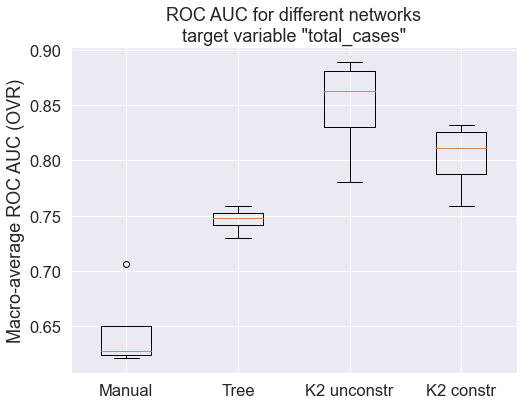

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(df_auc)
ax.set_ylabel("Macro-average ROC AUC (OVR)")
ax.set_xticklabels(["Manual", "Tree", "K2 unconstr", "K2 constr"])
plt.title("ROC AUC for different networks\ntarget variable \"total_cases\"");

### Discussion

The best architectures from the metrics point of view are automatically-generated models - structures based on best K2 score strategy with and without constraints.